In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from model_activations.models.utils import load_full_identifier, find_best_layer_iden
from model_activations.models.configs import model_cfg, analysis_cfg
from plotting_tools import *
from config import CACHE

R_VALUES_PATH = os.path.join(CACHE, 'bootstrap_r_values')
MULTIPLIER = 36

def load_and_prepare_data(model_name, multiplier, region):
    all_data = []
    filepath = os.path.join(R_VALUES_PATH, model_name + '_' + region + '.pkl')
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].astype(np.float32)
    return df

In [4]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'IT' # for majajhong: IT, for naturalscenes: ventral visual stream

In [11]:
# loading linear model data
df_random = load_and_prepare_data('random_model', MULTIPLIER, region)
# loading linear model data
df_expansion = load_and_prepare_data('expansion', MULTIPLIER, region)
#join dataframes
df = pd.concat([df_random,df_expansion]).reset_index(drop=True)

# alexnet data
with open(os.path.join(R_VALUES_PATH, 'alexnet' + '_' + region + '.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

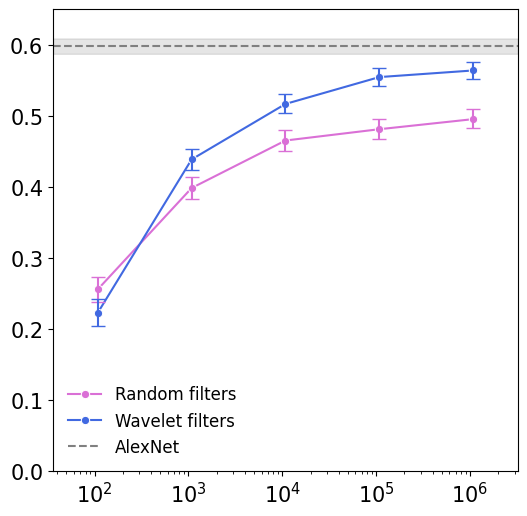

In [13]:
names ={'expansion':'Wavelet filters','random_model':'Random filters'}
palette ={'Wavelet filters':'royalblue', 'Random filters':'orchid'}
df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])


# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], 
                 df_alexnet['upper'], 
                 color='gray', alpha=0.2)


plt.ylim(0,0.30) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
plt.xlabel('')
plt.ylabel('')    
ax1.legend(frameon=False,fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.savefig(f'manuscript_figures/figure_s1_{DATASET}_{region}.png', dpi=200) 
plt.show()